## Data visualization

Your function returned a count of 8792  cars and  8968  not-cars with the type:  float32
of size:  (64, 64, 3)


(-0.5, 63.5, 63.5, -0.5)

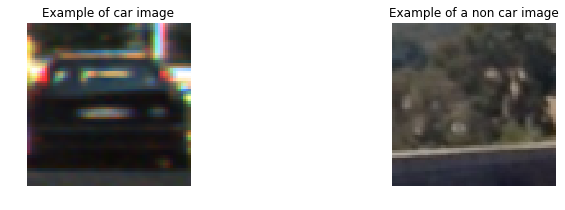

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
%matplotlib inline
from random import shuffle



cars = glob.glob('data/vehicles/*/*.*')
noncars = glob.glob('data/non-vehicles/*/*.*')
shuffle(cars)
shuffle(noncars)
        
#Define a function to return some characteristics of the dataset.
def data_look(car_list, notcar_list):
    data_dict = {}
    
    #Define a keydict for "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    #Define a keydict of "n_notcars" and store the number of notcar
    data_dict["n_notcars"] = len(notcar_list)
    
    #Read in a test image, either car or not
    example_img = mpimg.imread(car_list[0])
    
    #Define a key "image_shape" and store the test image shape in 3 tuple
    data_dict["image_shape"] = example_img.shape
    
    #Define a key "data_type"
    data_dict["data_type"] = example_img.dtype
    
    #Return the dictionary
    return data_dict 
    

data_info = data_look(cars, noncars)

print('Your function returned a count of', data_info["n_cars"], ' cars and ', data_info["n_notcars"], ' not-cars with the type: ', data_info["data_type"])
print('of size: ', data_info["image_shape"])

#Choose a random car and non car indices and plot example images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(noncars))


car_img = mpimg.imread(cars[car_ind])
noncar_img = mpimg.imread(noncars[notcar_ind])

#Plot the images.
fig = plt.figure(figsize= (12,3))
plt.subplot(1,2,1)
plt.imshow(car_img)
plt.title("Example of car image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(noncar_img)
plt.title("Example of a non car image")
plt.axis("off")



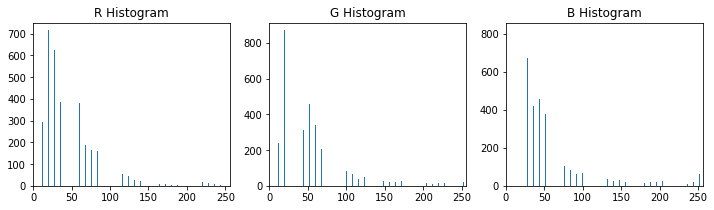

In [2]:
car_img = cv2.imread(cars[car_ind])

def color_hist(img, nbins=32, bins_range=(0, 256)):

    rhist = np.histogram(car_img[:,:,0], bins = 32, range = (0,256))
    ghist = np.histogram(car_img[:,:,1], bins = 32, range = (0,256))
    bhist = np.histogram(car_img[:,:,2], bins = 32, range = (0,256))

    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    return rhist, ghist, bhist, bin_centers, hist_features

rhist, ghist, bhist, bin_centers, feature_vec = color_hist(car_img)

if rhist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')

    plt.subplot(1, 3, 2)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')

    plt.subplot(1, 3, 3)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    
    plt.savefig('output_image/Color_hist.png', bbox_inches="tight")


else:
    print('Your function is returning None for at least one variable...')

#print(bin_edges)

## Visualization in 3D

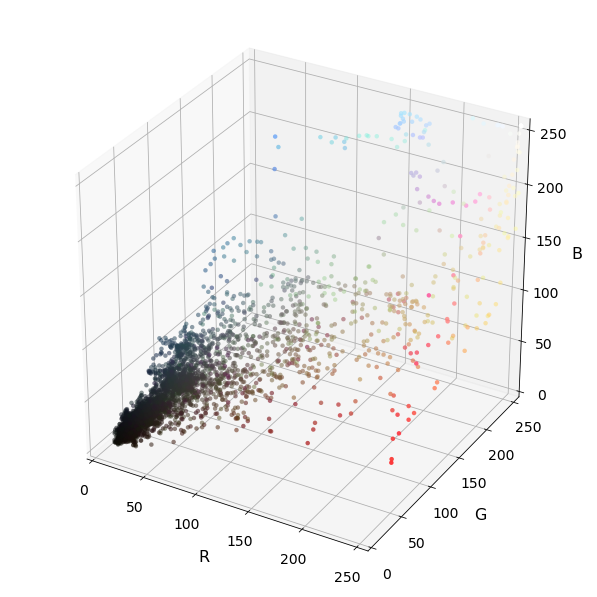

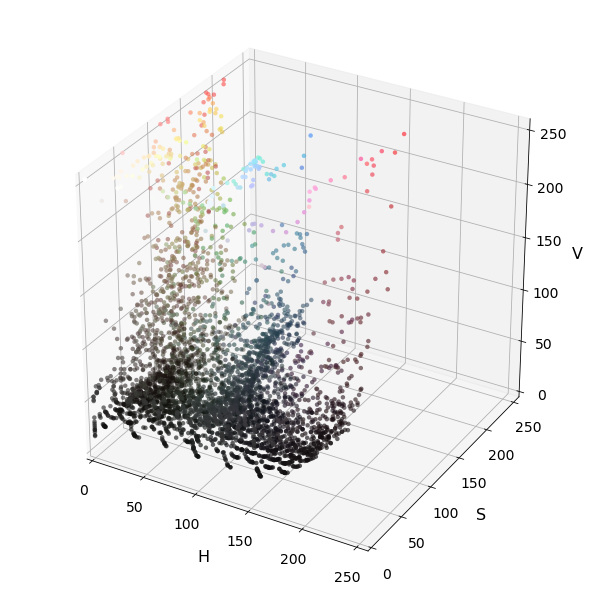

In [3]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    
    #Create a figure in 3D axes
    fig = plt.figure(figsize = (8, 8))
    ax = Axes3D(fig)
    
    #Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    #Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    
    #Plot  pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:,:,0].ravel(),
        pixels[:,:,1].ravel(),
        pixels[:,:,2].ravel(),
        c = colors_rgb.reshape((-1, 3)), edgecolors='none')
    
    return ax #return Axes3D object for further manipulation

img = cv2.imread(cars[car_ind])

#Select a small fractiono of pixels to plot by subsmapling it
scale = max(img.shape[0], img.shape[1], 64) / 64 #At most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

#Convert subsampled images to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  #Scaled to [0, 1] only for plotting

#Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plt.savefig('output_image/visualizationRGB_3D.png', bbox_inches="tight")

plot3d(img_small_HSV, img_small_rgb, axis_labels = list("HSV"))
plt.show()          

plt.savefig('output_image/visualizationHSV_3D.png', bbox_inches="tight")


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


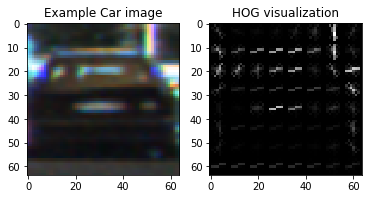

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        #Here I use skimage.hog() to get the features and the visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise = vis, feature_vector=False)
        
        return features, hog_image
    else:
        features= hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise = vis, feature_vector=feature_vec)
        
        return features
    
orient = 9
pix_per_cell = 8
cell_per_block = 2

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

#Now I want to plot the image

fig = plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title("Example Car image")
plt.subplot(122)
plt.savefig('output_image/HOG_without_example.png', bbox_inches="tight")

plt.imshow(hog_image, cmap='gray')
plt.title("HOG visualization")
plt.savefig('output_image/HOG_example.png', bbox_inches="tight")


## Bin spatial

In [5]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
                
    return features
              

## Function for extracting features

[[[ 39  39  88]
  [ 44  42  91]
  [ 62  55 102]
  ..., 
  [ 84  79  64]
  [ 73  79  67]
  [ 70  79  68]]

 [[ 39  43  89]
  [ 44  46  91]
  [ 62  58 101]
  ..., 
  [ 84  80  62]
  [ 73  79  65]
  [ 70  79  65]]

 [[ 41  58  92]
  [ 46  61  93]
  [ 63  71  97]
  ..., 
  [ 82  82  55]
  [ 73  79  55]
  [ 71  79  55]]

 ..., 
 [[ 18  18  15]
  [ 19  18  15]
  [ 20  18  15]
  ..., 
  [ 29  22  19]
  [ 31  26  24]
  [ 32  27  25]]

 [[ 20  24  22]
  [ 20  24  22]
  [ 22  24  22]
  ..., 
  [ 31  24  21]
  [ 32  27  23]
  [ 33  28  23]]

 [[ 20  25  24]
  [ 20  25  24]
  [ 22  25  23]
  ..., 
  [ 31  24  21]
  [ 32  27  22]
  [ 33  28  23]]]


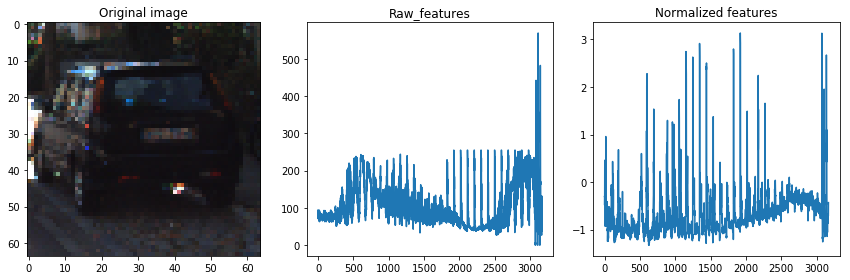

In [6]:
def color_histogram(img, nbins=32, bins_range=(0,256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def extract_features(image, cspace='RGB', spatial_size=(32,32), hist_bin=32, hist_range=(0,256)):
    features = []
    
    for img in image:
        imag = cv2.imread(img)
    
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(imag, cv2.COLOR_RGB2HSV)
            elif cspace =='LUV':
                feature_image = cv2.cvtColor(imag, cv2.COlOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(imag, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(imag, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(imag)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_histogram(img=feature_image)
        features.append(np.concatenate((spatial_features, hist_features)))
    
    return features

car_features = extract_features(cars, cspace='RGB')

if len(car_features) > 0:
    print(cv2.imread(cars[0]))
    #Create an array stack of feature vectors. Estoy metiendo todas las car features
    X = np.vstack((car_features)).astype(np.float64)
    #Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    #print(car_features)
    #print(X)
    #Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[5]))
    plt.title('Original image')
    plt.subplot(132)
    #There is only one position
    plt.plot(X[1])
    plt.title('Raw_features')
    plt.subplot(133)
    plt.plot(scaled_X[5])
    plt.title('Normalized features')
    fig.tight_layout()
    
    plt.savefig('output_image/Features.png', bbox_inches="tight")

else:
    print('Your function only returns empty feature vectors...')

## Sliding Window Search (Find cars)

In [7]:
from tqdm import tqdm
def convert_color(img, conv):
    if conv == 'RGB2YCrCb':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    '''
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))
    '''
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=False)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    bins_range=(0, 256)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    #Generate bin centers
    bin_edges = channel1_hist[1] #All the 3 bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2

    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
            # Return the individual histograms, bin_centers and feature vector
        return hist_features

def extract_features2(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] #https://github.com/preritj/Vechicle-Detection-Tracking
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

'''
ystart = 400
ystop = 656
scale = 2
svc = 
pix_per_cell= 8
cell_per_block= 2
spatial_size=(32, 32)
hist_bins = 32
orient = 9



img = mpimg.imread('test_image.jpg')
car_features = extract_features2(cars, color_space='RGB', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
notcar_features = extract_features2(noncars, color_space='RGB', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)


X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(out_img)
'''

"\nystart = 400\nystop = 656\nscale = 2\nsvc = \npix_per_cell= 8\ncell_per_block= 2\nspatial_size=(32, 32)\nhist_bins = 32\norient = 9\n\n\n\nimg = mpimg.imread('test_image.jpg')\ncar_features = extract_features2(cars, color_space='RGB', \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block)\nnotcar_features = extract_features2(noncars, color_space='RGB', \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block)\n\n\nX = np.vstack((car_features, notcar_features)).astype(np.float64)\nX_scaler = StandardScaler().fit(X)\n# Apply the scaler to X\nscaled_X = X_scaler.transform(X)\n\ny = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))\n\nrand_state = np.random.randint(0, 100)\nX_train, X_

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import time

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

car_features = extract_features2(cars, hog_feat=True)
notcar_features = extract_features2(noncars, hog_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

  0%|          | 0/8792 [00:00<?, ?it/s]/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8968/8968 [00:31<00:00, 287.67it/s]


18.15 seconds to train SVC.
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


In [9]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC: 96.96%

  Predictions: [ 0.  0.  0.  1.  1.  1.  1.  1.  0.  0.]
       Labels: [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]

0.00296 seconds to predict 10 labels with SVC.


## Training and testing Color Histogram Support Vector Classifier

In [10]:
from sklearn.model_selection import train_test_split
import time

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


car_features = extract_features2(cars, hog_feat=True)
noncar_features = extract_features2(noncars, hog_feat=True)

#Stack the features vectors in vertical
X = np.vstack((car_features, noncar_features)).astype(np.float64)
#Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
#Apply the scaler to x
scaled_X = X_scaler.transform(X)

#Labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

#Use a linear SVC
svc = LinearSVC()
#How much time does it take for the training
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using: ', orient, 'orientations', pix_per_cell, 'pixels per cells', cell_per_block, 'cells per block')
print('Feature vector lenght:', len(X_train[0]))

  0%|          | 0/8792 [00:00<?, ?it/s]/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8968/8968 [00:27<00:00, 321.80it/s]


20.09 seconds to train SVC.
Using:  9 orientations 8 pixels per cells 2 cells per block
Feature vector lenght: 4932


In [11]:
print('Test accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t = time.time()
#I want to predict only 10 labels

print('   Predictions: ', svc.predict(X_test[0:10]))
print('     Labels:' , y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels')

Test accuracy of SVC: 97.35%

   Predictions:  [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]
     Labels: [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]

0.00356 seconds to predict 10 labels


## Implementing Sliding Window

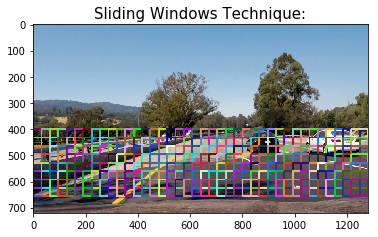

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    #Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    #Compute the number of pixels per step in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 255, 255), thick=6, random_color=False):
    #Make a copy of the image
    imcopy = np.copy(img)
    #Iterate through the bounding boxes
    for bbox in bboxes:
        #Use different colors so we can appreciate overlap
        if random_color == True:
            color = (np.random.randint(0, 255), np.random.randint(0,255), np.random.randint(0,255))
        #Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    return imcopy


test_image = mpimg.imread('test_images/test4.jpg')

windows = slide_window(test_image, x_start_stop=[None, None],
                       y_start_stop=[400, 656], xy_window= (64, 64),
                      xy_overlap=(0.5, 0.5))

windows_img = draw_boxes(test_image, windows, random_color=True)
plt.imshow(windows_img)
#matplotlib.rc('xtick', labelsize=15)
#matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:', fontsize=15);
plt.savefig('output_image/sliding_windows.png', bbox_inches="tight")



## Extract features from a single image

In [13]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        #print('Size of features before concatenate: ', img_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Search Windows Function

In [14]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Train the classifier and test the predictions

In [15]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features2(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features2(noncars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)

  0%|          | 0/8792 [00:00<?, ?it/s]/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8968/8968 [01:02<00:00, 144.03it/s]


In [16]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
#Fit a per column scaler
X_scaler = StandardScaler().fit(X)
#Apply the scaler to X
scaled_X = X_scaler.transform(X)

#Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Split data into randomized sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientantions', pix_per_cell, 'pixels_per_cell and', cell_per_block, 'cells_per_block')
print('Feature vector length:', len(X_train[0]))

#Use a linear SVC
svc = LinearSVC()

#Check the training time for the SVC
t= time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

#Check the score of the SVC
print('Test Accuracy of the SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))

#Check the prediction time for a single sample
t=time.time()

Using: 10 orientantions 8 pixels_per_cell and 2 cells_per_block
Feature vector length: 9144
27.91 Seconds to train SVC...
Test Accuracy of the SVC = 98.68%


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


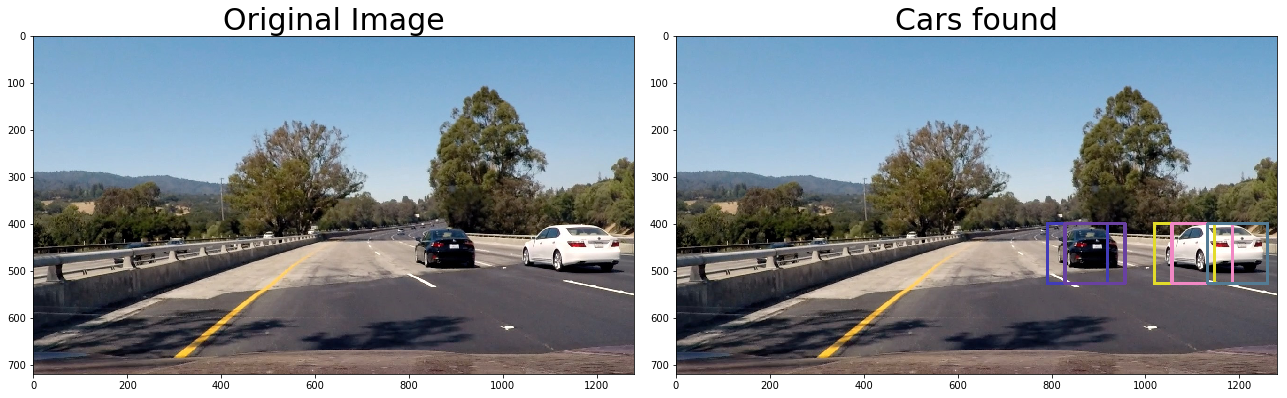

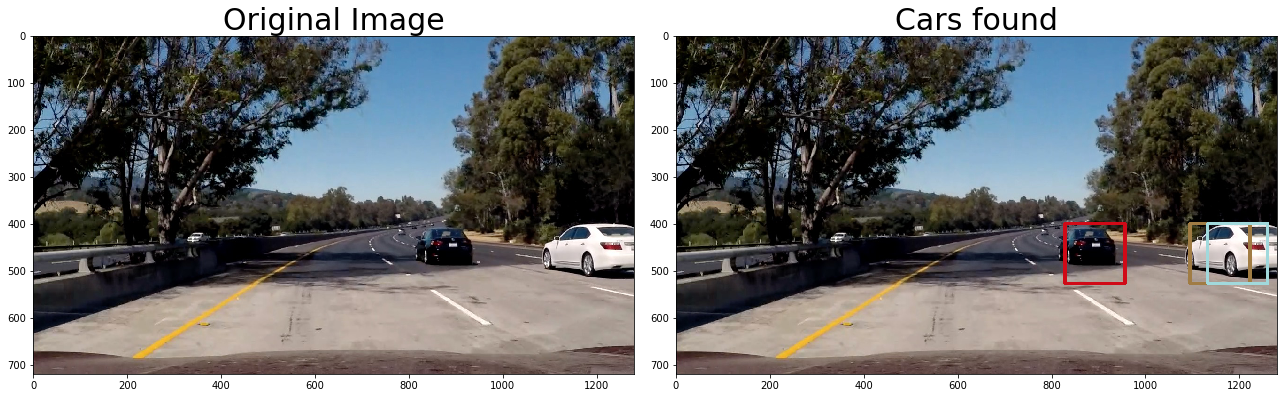

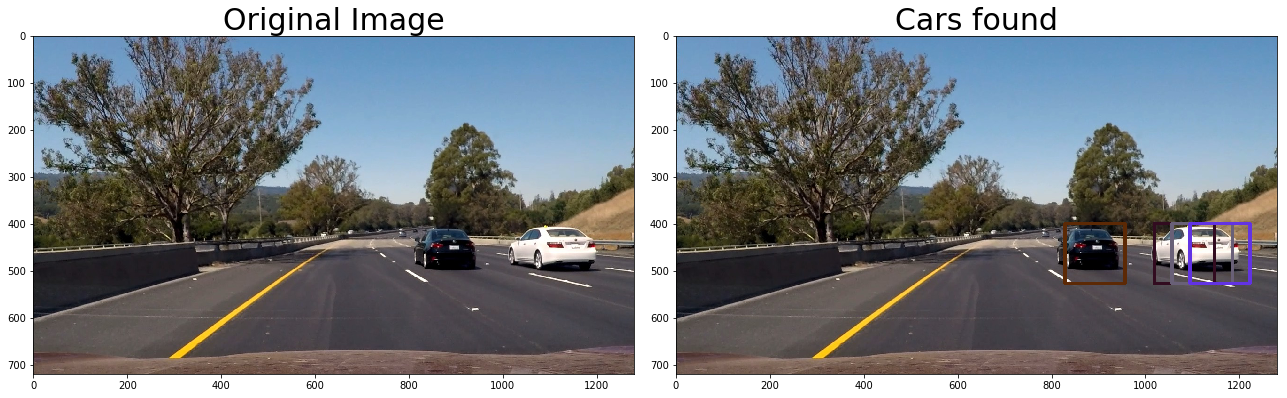

In [17]:
for i in range(4,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    
    #If the image you are searching is a .jpg (scaled from 0 to 255)
    image = image.astype(np.float32)/255
    
    test_img = mpimg.imread('test_images/test4.jpg')
    windows = slide_window(test_img, x_start_stop = [600, None], y_start_stop = [400, 656],
                          xy_window=(128, 128), xy_overlap = (.7,.7))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_image, hot_windows, random_color=True)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    plt.savefig('output_image/windows.png', bbox_inches="tight")

## Adding Heatmaps and Bounding Boxes

In [18]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    #Iterate through a list of bboxes
    for box in bbox_list: 
        #Add += 1 for all the pixels inside each bbox
        #Each bbox takes the from ((x1, x2), (y1, y2))
        #They represent the pixels to be drawn
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    return heatmap 

def apply_threshold(heatmap, threshold):
    #A filter for eliminating false positives
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    #Iterate trough all detected cars
    for car_number in range(1, labels[1]+1):
        #Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        #Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
     
        #Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 8)
    #Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## Heatmap tests

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


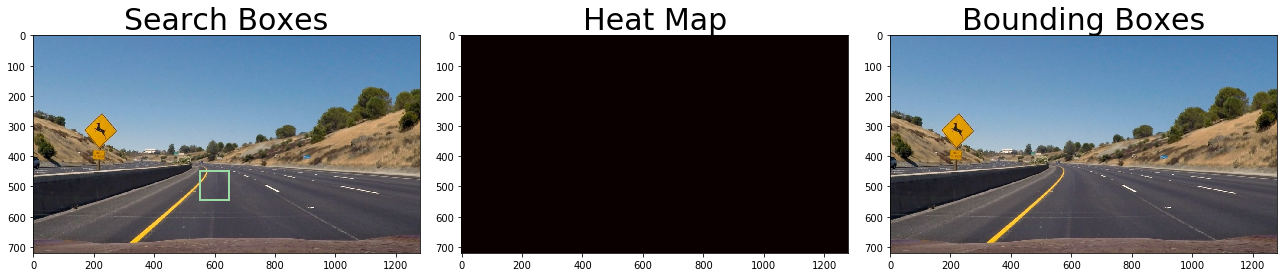

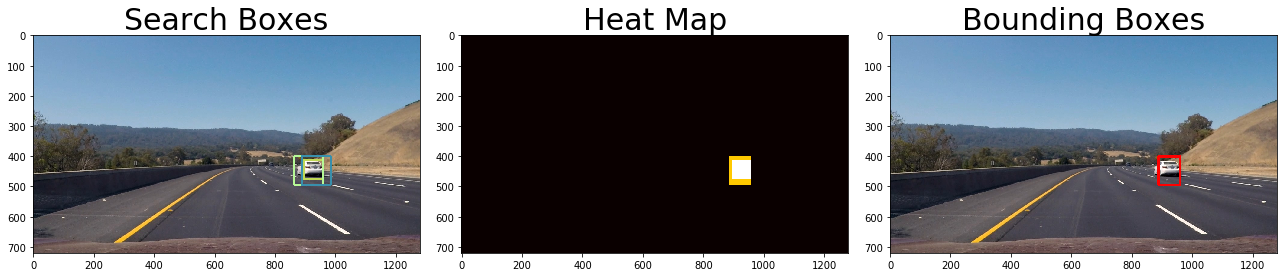

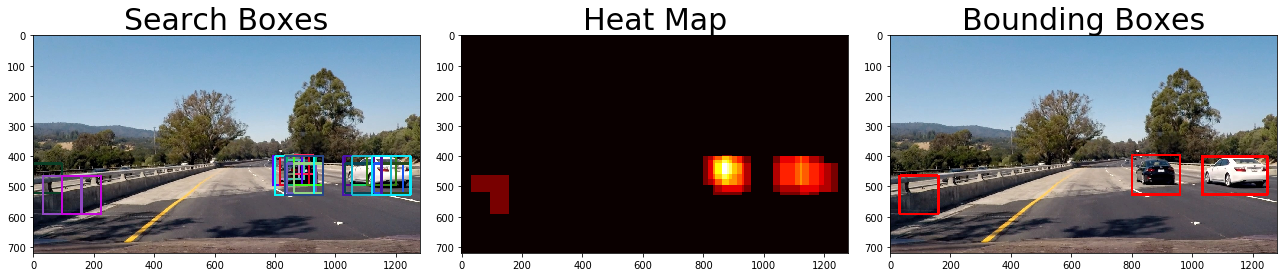

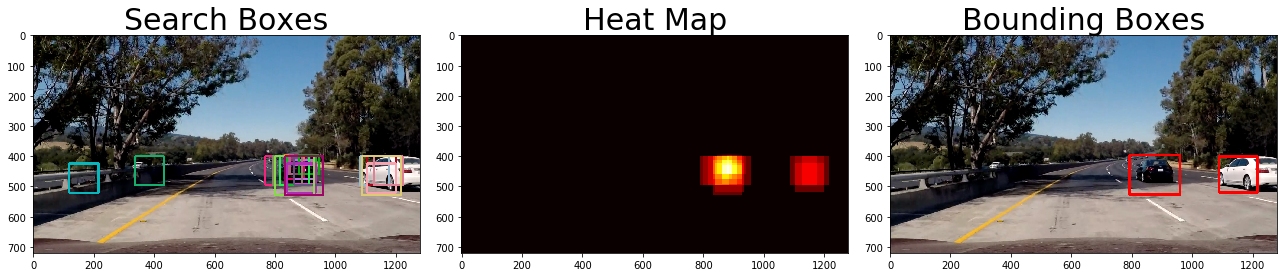

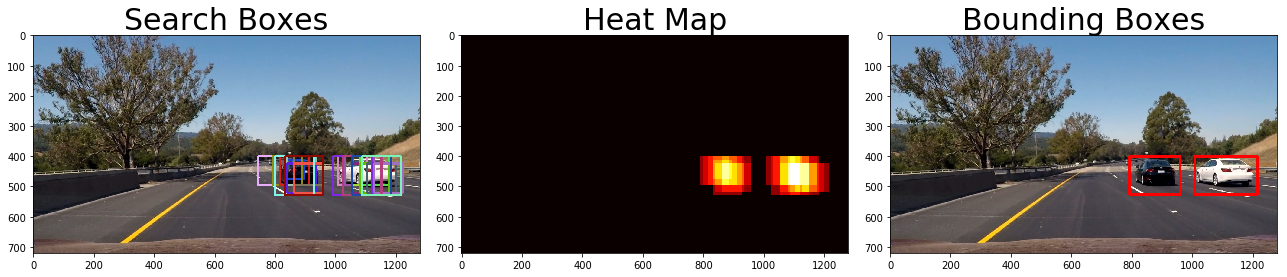

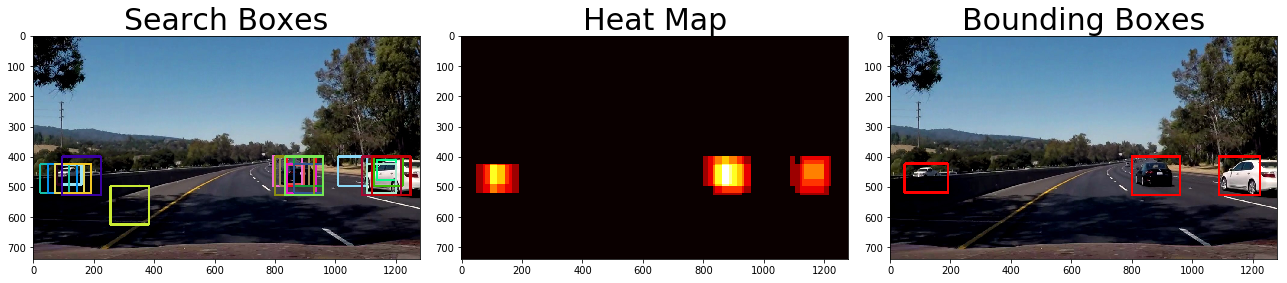

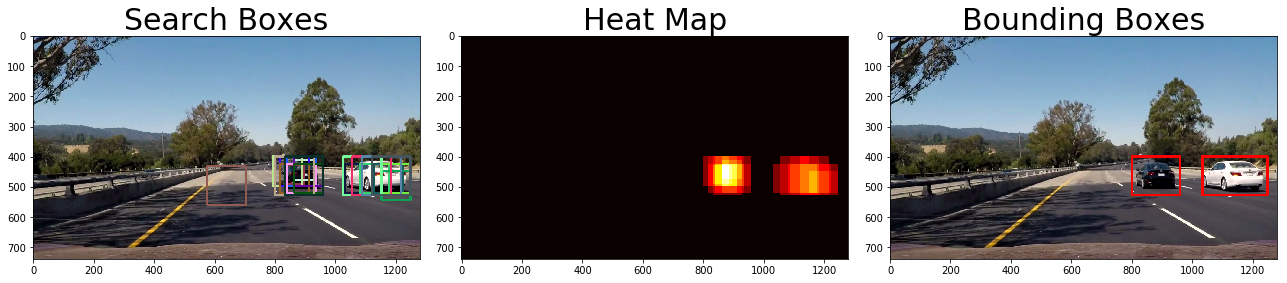

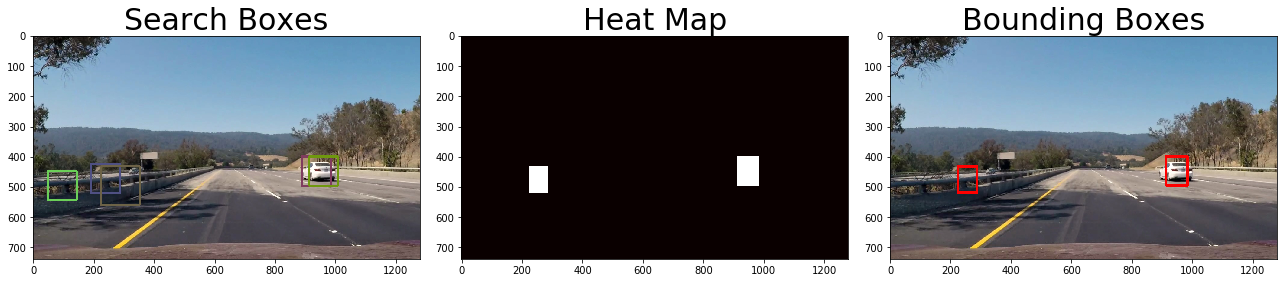

In [19]:
for i in range(2, 10):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                               orient, pix_per_cell, cell_per_block, 
                               spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                              orient, pix_per_cell, cell_per_block,
                              spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                              orient, pix_per_cell, cell_per_block,
                              spatial_size, hist_bins))
    #Flatten list
    bbox_list = [item for sublist in bbox_list for item in sublist]
    
    out_img = draw_boxes(img, bbox_list, random_color = True)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 1)
    
    #Find the final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    

In [20]:
def process_image(img):
    
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32,32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 1)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

## Video Output

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = "test_videos/test_output.mp4"
clip = VideoFileClip("test_videos/test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos/test_output.mp4
[MoviePy] Writing video test_videos/test_output.mp4


 97%|█████████▋| 38/39 [00:49<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/test_output.mp4 

CPU times: user 49.2 s, sys: 228 ms, total: 49.4 s
Wall time: 50 s


In [23]:
output = "test_videos/project_output.mp4"
clip = VideoFileClip("test_videos/project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos/project_output.mp4
[MoviePy] Writing video test_videos/project_output.mp4


100%|█████████▉| 1260/1261 [26:49<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/project_output.mp4 

CPU times: user 26min 54s, sys: 4.82 s, total: 26min 59s
Wall time: 26min 50s
